In [2]:
# Load the video data 
import numpy as np
import skvideo.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.widgets import Slider, Button
from tqdm import tqdm
from queue import Queue
import scipy.optimize as opt
import pickle
import pandas as pd
import xarray as xr
from timeit import default_timer as timer
%matplotlib inline

In [3]:
filename = "sample.mp4" 
frames_to_load = 7273 # this is necessary because it seems to crash at the end of the video 

moviedata = skvideo.io.vread(filename, num_frames=frames_to_load)

crop = 50
test_frames = np.random.permutation(frames_to_load)[:100]

raw = moviedata[test_frames, crop:-crop, crop:-crop, 0]

[T, X, Y] = raw.shape
x = np.arange(-X/2, X/2)
y = np.arange(-Y/2, Y/2)
#print(np.size(x),np.size(y))
x2d, y2d = np.meshgrid(y, x)
radius = np.sqrt(x2d**2 + y2d**2)
print(T, X, Y)

100 284 284


In [4]:
def check_adjacent(i, j, data, status, q):
    # process adjacent pixels and add them to the queue if need be 
    if not status[i, j]:
        if data[i, j]:
            q.put([i, j])
        else: 
            status[i, j] = True

def find_connected_components(data):
    [X, Y] = data.shape
    curr = 0
    labels = np.zeros_like(data, dtype=int) - 1
    status = np.zeros_like(data, dtype=bool)
    q1 = Queue()
    q2 = Queue()
    for i in range(X):
        for j in range(Y):

            # skip this pixel if we already got it
            if status[i, j]:
                continue

            # if this pixel is false, flag it as processed and continue
            if not data[i, j]:
                status[i, j] = True
                continue
        
            # check adjacent pixels and add them to the queue if needed 
            check_adjacent(i, (j+1)%Y, data, status, q1)
            check_adjacent(i, (j-1)%Y, data, status, q1)
            check_adjacent((i+1)%X, j, data, status, q1)
            check_adjacent((i-1)%X, j, data, status, q1)
            labels[i, j] = curr
            status[i, j] = True
            # process the queue
            while not q1.empty():
                [a, b] = q1.get()
                check_adjacent(a, (b+1)%Y, data, status, q2)
                check_adjacent(a, (b-1)%Y, data, status, q2)
                check_adjacent((a+1)%X, b, data, status, q2)
                check_adjacent((a-1)%X, b, data, status, q2)
                labels[a, b] = curr
                status[a, b] = True
                while not q2.empty():
                    q1.put(q2.get())
            curr += 1

    return labels, curr-1



# let's do a steamlined version of this pipeline, to try to design maximally efficient filters

def std_n_particles(x):
    start = timer()
    filter_scale, threshfrac = x

    real_space_filter = np.exp(-2 * (radius / filter_scale)**2) * (1 - 2 * (radius / filter_scale)**4)

    fft_data = np.fft.fft2(raw, axes=[1, 2])
    fourier_filter = np.fft.fft2(np.fft.fftshift(real_space_filter))
    filtered = np.real(np.fft.ifft2(fft_data*fourier_filter))

    threshold = np.amax(filtered) * threshfrac

    thresh = np.copy(filtered)
    thresh[thresh < threshold] = 0
    thresh[thresh > 0] = 1
    binary = np.asarray(thresh, dtype=bool)

    particle = np.zeros_like(raw, dtype=int)
    n_particles = np.zeros(T, dtype=int)

    for t in tqdm(range(T)):
        l, n = find_connected_components(binary[t])
        particle[t] = l
        n_particles[t] = n

    vals, counts = np.unique(n_particles, return_counts=True) 
    end = timer()
    return vals, counts, end - start


In [39]:
scalearr = np.arange(2, 5, 0.25)
threshfracs = np.arange(0.2, 0.6, 0.025)
S = len(scalearr)
F = len(threshfracs)
res = []
for i, s in enumerate(scalearr):
    curr = []
    for j, f in enumerate(threshfracs): 
        print(f"s = {s}, f = {f}")
        curr.append(std_n_particles((s, f)))
    res.append(curr)
    

s = 2.0, f = 0.2


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


s = 2.0, f = 0.225


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


s = 2.0, f = 0.25


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


s = 2.0, f = 0.275


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


s = 2.0, f = 0.3


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


s = 2.0, f = 0.32499999999999996


100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


s = 2.0, f = 0.35


100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


s = 2.0, f = 0.375


100%|██████████| 100/100 [00:05<00:00, 18.79it/s]


s = 2.0, f = 0.39999999999999997


100%|██████████| 100/100 [00:04<00:00, 23.02it/s]


s = 2.0, f = 0.42499999999999993


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


s = 2.0, f = 0.44999999999999996


100%|██████████| 100/100 [00:03<00:00, 33.14it/s]


s = 2.0, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


s = 2.0, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 44.48it/s]


s = 2.0, f = 0.5249999999999999


100%|██████████| 100/100 [00:02<00:00, 49.83it/s]


s = 2.0, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 54.41it/s]


s = 2.0, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 58.25it/s]


s = 2.25, f = 0.2


100%|██████████| 100/100 [00:33<00:00,  2.94it/s]


s = 2.25, f = 0.225


100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


s = 2.25, f = 0.25


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


s = 2.25, f = 0.275


100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


s = 2.25, f = 0.3


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


s = 2.25, f = 0.32499999999999996


100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


s = 2.25, f = 0.35


100%|██████████| 100/100 [00:06<00:00, 15.40it/s]


s = 2.25, f = 0.375


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


s = 2.25, f = 0.39999999999999997


100%|██████████| 100/100 [00:04<00:00, 22.99it/s]


s = 2.25, f = 0.42499999999999993


100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


s = 2.25, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 33.48it/s]


s = 2.25, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


s = 2.25, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 44.82it/s]


s = 2.25, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 50.06it/s]


s = 2.25, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 54.77it/s]


s = 2.25, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 58.35it/s]


s = 2.5, f = 0.2


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


s = 2.5, f = 0.225


100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


s = 2.5, f = 0.25


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


s = 2.5, f = 0.275


100%|██████████| 100/100 [00:09<00:00, 10.50it/s]


s = 2.5, f = 0.3


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


s = 2.5, f = 0.32499999999999996


100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


s = 2.5, f = 0.35


100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


s = 2.5, f = 0.375


100%|██████████| 100/100 [00:04<00:00, 20.03it/s]


s = 2.5, f = 0.39999999999999997


100%|██████████| 100/100 [00:04<00:00, 24.10it/s]


s = 2.5, f = 0.42499999999999993


100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


s = 2.5, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 33.95it/s]


s = 2.5, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


s = 2.5, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 45.34it/s]


s = 2.5, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 50.38it/s]


s = 2.5, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 54.95it/s]


s = 2.5, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 58.39it/s]


s = 2.75, f = 0.2


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


s = 2.75, f = 0.225


100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


s = 2.75, f = 0.25


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


s = 2.75, f = 0.275


100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


s = 2.75, f = 0.3


100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


s = 2.75, f = 0.32499999999999996


100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


s = 2.75, f = 0.35


100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


s = 2.75, f = 0.375


100%|██████████| 100/100 [00:04<00:00, 21.69it/s]


s = 2.75, f = 0.39999999999999997


100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


s = 2.75, f = 0.42499999999999993


100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


s = 2.75, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


s = 2.75, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


s = 2.75, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 44.91it/s]


s = 2.75, f = 0.5249999999999999


100%|██████████| 100/100 [00:02<00:00, 49.90it/s]


s = 2.75, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 54.60it/s]


s = 2.75, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 58.42it/s]


s = 3.0, f = 0.2


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


s = 3.0, f = 0.225


100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


s = 3.0, f = 0.25


100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


s = 3.0, f = 0.275


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


s = 3.0, f = 0.3


100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


s = 3.0, f = 0.32499999999999996


100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


s = 3.0, f = 0.35


100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


s = 3.0, f = 0.375


100%|██████████| 100/100 [00:04<00:00, 23.01it/s]


s = 3.0, f = 0.39999999999999997


100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


s = 3.0, f = 0.42499999999999993


100%|██████████| 100/100 [00:03<00:00, 30.19it/s]


s = 3.0, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


s = 3.0, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


s = 3.0, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 43.98it/s]


s = 3.0, f = 0.5249999999999999


100%|██████████| 100/100 [00:02<00:00, 48.63it/s]


s = 3.0, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 53.48it/s]


s = 3.0, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 57.43it/s]


s = 3.25, f = 0.2


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


s = 3.25, f = 0.225


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


s = 3.25, f = 0.25


100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


s = 3.25, f = 0.275


100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


s = 3.25, f = 0.3


100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


s = 3.25, f = 0.32499999999999996


100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


s = 3.25, f = 0.35


100%|██████████| 100/100 [00:04<00:00, 21.97it/s]


s = 3.25, f = 0.375


100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


s = 3.25, f = 0.39999999999999997


100%|██████████| 100/100 [00:03<00:00, 28.68it/s]


s = 3.25, f = 0.42499999999999993


100%|██████████| 100/100 [00:03<00:00, 32.47it/s]


s = 3.25, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 36.51it/s]


s = 3.25, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 41.04it/s]


s = 3.25, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 45.65it/s]


s = 3.25, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 50.58it/s]


s = 3.25, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 55.09it/s]


s = 3.25, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 58.86it/s]


s = 3.5, f = 0.2


100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


s = 3.5, f = 0.225


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


s = 3.5, f = 0.25


100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


s = 3.5, f = 0.275


100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


s = 3.5, f = 0.3


100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


s = 3.5, f = 0.32499999999999996


100%|██████████| 100/100 [00:04<00:00, 20.26it/s]


s = 3.5, f = 0.35


100%|██████████| 100/100 [00:04<00:00, 23.20it/s]


s = 3.5, f = 0.375


100%|██████████| 100/100 [00:03<00:00, 26.50it/s]


s = 3.5, f = 0.39999999999999997


100%|██████████| 100/100 [00:03<00:00, 29.99it/s]


s = 3.5, f = 0.42499999999999993


100%|██████████| 100/100 [00:02<00:00, 33.85it/s]


s = 3.5, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 37.85it/s]


s = 3.5, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 42.29it/s]


s = 3.5, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 46.79it/s]


s = 3.5, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 51.24it/s]


s = 3.5, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 55.67it/s]


s = 3.5, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 59.16it/s]


s = 3.75, f = 0.2


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


s = 3.75, f = 0.225


100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


s = 3.75, f = 0.25


100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


s = 3.75, f = 0.275


100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


s = 3.75, f = 0.3


100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


s = 3.75, f = 0.32499999999999996


100%|██████████| 100/100 [00:04<00:00, 21.04it/s]


s = 3.75, f = 0.35


100%|██████████| 100/100 [00:04<00:00, 24.00it/s]


s = 3.75, f = 0.375


100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


s = 3.75, f = 0.39999999999999997


100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


s = 3.75, f = 0.42499999999999993


100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


s = 3.75, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 38.84it/s]


s = 3.75, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 43.03it/s]


s = 3.75, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 47.45it/s]


s = 3.75, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 51.80it/s]


s = 3.75, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 55.78it/s]


s = 3.75, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 59.52it/s]


s = 4.0, f = 0.2


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


s = 4.0, f = 0.225


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


s = 4.0, f = 0.25


100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


s = 4.0, f = 0.275


100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


s = 4.0, f = 0.3


100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


s = 4.0, f = 0.32499999999999996


100%|██████████| 100/100 [00:04<00:00, 21.52it/s]


s = 4.0, f = 0.35


100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


s = 4.0, f = 0.375


100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


s = 4.0, f = 0.39999999999999997


100%|██████████| 100/100 [00:03<00:00, 31.69it/s]


s = 4.0, f = 0.42499999999999993


100%|██████████| 100/100 [00:02<00:00, 35.52it/s]


s = 4.0, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


s = 4.0, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 43.84it/s]


s = 4.0, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 48.25it/s]


s = 4.0, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 52.68it/s]


s = 4.0, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 56.54it/s]


s = 4.0, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 59.96it/s]


s = 4.25, f = 0.2


100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


s = 4.25, f = 0.225


100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


s = 4.25, f = 0.25


100%|██████████| 100/100 [00:07<00:00, 13.96it/s]


s = 4.25, f = 0.275


100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


s = 4.25, f = 0.3


100%|██████████| 100/100 [00:05<00:00, 19.01it/s]


s = 4.25, f = 0.32499999999999996


100%|██████████| 100/100 [00:04<00:00, 21.87it/s]


s = 4.25, f = 0.35


100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


s = 4.25, f = 0.375


100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


s = 4.25, f = 0.39999999999999997


100%|██████████| 100/100 [00:03<00:00, 32.35it/s]


s = 4.25, f = 0.42499999999999993


100%|██████████| 100/100 [00:02<00:00, 36.34it/s]


s = 4.25, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 40.67it/s]


s = 4.25, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 44.93it/s]


s = 4.25, f = 0.49999999999999994


100%|██████████| 100/100 [00:02<00:00, 49.37it/s]


s = 4.25, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 53.44it/s]


s = 4.25, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 57.38it/s]


s = 4.25, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 60.59it/s]


s = 4.5, f = 0.2


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


s = 4.5, f = 0.225


100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


s = 4.5, f = 0.25


100%|██████████| 100/100 [00:07<00:00, 14.16it/s]


s = 4.5, f = 0.275


100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


s = 4.5, f = 0.3


100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


s = 4.5, f = 0.32499999999999996


100%|██████████| 100/100 [00:04<00:00, 22.58it/s]


s = 4.5, f = 0.35


100%|██████████| 100/100 [00:03<00:00, 25.87it/s]


s = 4.5, f = 0.375


100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


s = 4.5, f = 0.39999999999999997


100%|██████████| 100/100 [00:02<00:00, 33.67it/s]


s = 4.5, f = 0.42499999999999993


100%|██████████| 100/100 [00:02<00:00, 38.02it/s]


s = 4.5, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 42.43it/s]


s = 4.5, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 46.86it/s]


s = 4.5, f = 0.49999999999999994


100%|██████████| 100/100 [00:01<00:00, 51.29it/s]


s = 4.5, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 55.10it/s]


s = 4.5, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 58.68it/s]


s = 4.5, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 61.69it/s]


s = 4.75, f = 0.2


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


s = 4.75, f = 0.225


100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


s = 4.75, f = 0.25


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


s = 4.75, f = 0.275


100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


s = 4.75, f = 0.3


100%|██████████| 100/100 [00:04<00:00, 20.00it/s]


s = 4.75, f = 0.32499999999999996


100%|██████████| 100/100 [00:04<00:00, 23.34it/s]


s = 4.75, f = 0.35


100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


s = 4.75, f = 0.375


100%|██████████| 100/100 [00:03<00:00, 31.05it/s]


s = 4.75, f = 0.39999999999999997


100%|██████████| 100/100 [00:02<00:00, 35.23it/s]


s = 4.75, f = 0.42499999999999993


100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


s = 4.75, f = 0.44999999999999996


100%|██████████| 100/100 [00:02<00:00, 44.39it/s]


s = 4.75, f = 0.475


100%|██████████| 100/100 [00:02<00:00, 48.89it/s]


s = 4.75, f = 0.49999999999999994


100%|██████████| 100/100 [00:01<00:00, 53.03it/s]


s = 4.75, f = 0.5249999999999999


100%|██████████| 100/100 [00:01<00:00, 56.85it/s]


s = 4.75, f = 0.5499999999999999


100%|██████████| 100/100 [00:01<00:00, 59.51it/s]


s = 4.75, f = 0.575


100%|██████████| 100/100 [00:01<00:00, 62.17it/s]


In [42]:
# optimizationresults = {"scalearr": scalearr, "threshfracs": threshfracs, "res": res}
# pickle.dump(optimizationresults, open("optimizationresults.p", "wb"))

In [3]:

optimizationresults = pickle.load(open("optimizationresults.p", "rb"))
res = optimizationresults["res"]
scalearr = np.arange(2, 5, 0.25)
threshfracs = np.arange(0.2, 0.6, 0.025)
S = len(scalearr)
F = len(threshfracs)

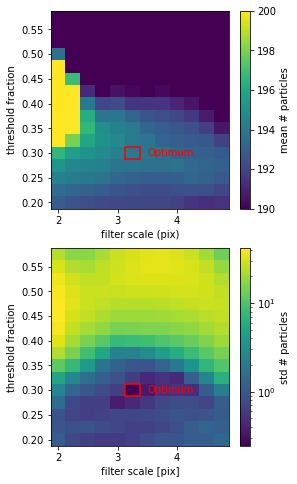

In [16]:
avgparticles = np.zeros((S, F))
stdparticles = np.zeros((S, F))
times = np.zeros((S, F))
for i, s in enumerate(scalearr):
    for j, f in enumerate(threshfracs):
        avgparticles[i, j] = np.sum(res[i][j][0] * res[i][j][1])/np.sum(res[i][j][1])
        stdparticles[i, j] = np.sqrt(np.sum(
            res[i][j][1] * (res[i][j][0]-avgparticles[i, j])**2)/np.sum(res[i][j][1]))
        times[i, j] = res[i][j][2]
        
avgparticles = np.transpose(avgparticles)
stdparticles = np.transpose(stdparticles)

xbest = 3.125 + np.array([0, 0.25, 0.25, 0, 0])
ybest = 0.2875 + np.array([0, 0, 0.025, 0.025, 0])

plt.figure(figsize=(4,8))
plt.title("Particle detection accuracy and efficiency vs. filter scale and threshold fraction")
plt.subplot(2, 1, 1)
# bounds = np.array([0, 191, 192, 193, 194, 195, 196, 197, 198, 199, 300])
# plt.pcolormesh(threshfracs, scalearr, avgparticles, norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256))
plt.pcolormesh(scalearr, threshfracs, avgparticles, vmin=190, vmax=200)
plt.plot(xbest, ybest, color="red")
plt.text(3.5, 0.3, "Optimum", color="red", verticalalignment="center")
plt.xlabel("filter scale (pix)")
plt.ylabel("threshold fraction")
# plt.colorbar(label="mean # particles (very nonlinear colorbar!)")
plt.colorbar(label="mean # particles")
plt.subplot(2, 1, 2)
plt.pcolormesh(scalearr, threshfracs, stdparticles, norm=colors.LogNorm())
plt.plot(xbest, ybest, color="red")
plt.text(3.5, 0.3, "Optimum", color="red", verticalalignment="center")
plt.xlabel("filter scale [pix]")
plt.ylabel("threshold fraction")
plt.colorbar(label="std # particles")
plt.savefig("optimizationresults.pdf")
plt.show()

In [54]:
# what is the actual value of threshold for the max threshfrac and filterscale here? 


filter_scale, threshfrac = (3.25, 0.3)

real_space_filter = np.exp(-2 * (radius / filter_scale)**2) * (1 - 2 * (radius / filter_scale)**4)

fft_data = np.fft.fft2(raw, axes=[1, 2])
fourier_filter = np.fft.fft2(np.fft.fftshift(real_space_filter))
filtered = np.real(np.fft.ifft2(fft_data*fourier_filter))

threshold = np.amax(filtered) * threshfrac
print(threshold)

240.6991028224026


In [ ]:
# so for our data run, let's us filter_scale 3.25 and threshold 240!